In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("./data/processed_salary_dataset.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,Others,103497,Some-college,10,Never-married,Others,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']


In [17]:
numerical_columns = [col for col in df.columns if col not in categorical_columns]
print(numerical_columns)

['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [5]:
from sklearn.preprocessing import LabelEncoder

df_label_encoded = df.copy()
le = LabelEncoder()
for col in categorical_columns:
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])
df_label_encoded.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,226802,1,7,4,6,3,2,1,0,0,40,39,0
1,38,3,89814,8,9,2,4,0,4,1,0,0,50,39,0
2,28,1,336951,4,12,2,11,0,4,1,0,0,40,39,1
3,44,3,160323,11,10,2,6,0,2,1,7688,0,40,39,1
4,18,2,103497,11,10,4,8,3,4,0,0,0,30,39,0


In [6]:
df= df_label_encoded
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,226802,1,7,4,6,3,2,1,0,0,40,39,0
1,38,3,89814,8,9,2,4,0,4,1,0,0,50,39,0
2,28,1,336951,4,12,2,11,0,4,1,0,0,40,39,1
3,44,3,160323,11,10,2,6,0,2,1,7688,0,40,39,1
4,18,2,103497,11,10,4,8,3,4,0,0,0,30,39,0


In [7]:
X=df.drop("income",axis=1)
y=df["income"]

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [9]:
#Testing Models
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score

def evaluate_models(X_train, y_train, X_test, y_test, models, params, cv=5, scoring='accuracy'):
    results = {}
    best_model = None
    best_score = 0
    best_model_name = None
    best_model_params = None

    for model_name, model in models.items():
        print(f"Training and tuning {model_name}...")
        param_grid = params[model_name]
        grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring)
        grid.fit(X_train, y_train)
        
        best_estimator = grid.best_estimator_
        y_pred = best_estimator.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec=precision_score(y_test,y_pred)
        rec=recall_score(y_test,y_pred)
        f1=f1_score(y_test,y_pred)
        roc=roc_auc_score(y_test,y_pred)
        
        results[model_name] = {
            'accuracy': acc,
            'precision':prec,
            'recall':rec,
            'f1 score':f1,
            'roc_auc_score':roc,
            'best_params': grid.best_params_,
            'model': best_estimator
        }

        if acc > best_score:
            best_score = acc
            best_model = best_estimator
            best_model_name = model_name
            best_model_params = grid.best_params_
    
    print(f"\nBest model: {best_model_name} with accuracy: {best_score:.4f}")
    
    return {
        'all_results': results,
        'best_model_name': best_model_name,
        'best_model': best_model,
        'best_accuracy': best_score,
        'best_params': best_model_params
    }


In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1500),
    'NaiveBayes': GaussianNB(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'KNN': KNeighborsClassifier()
}

# Define hyperparameters
params = {
    'LogisticRegression': {
        'C': [0.001,0.01,0.1, 1],
        'solver': ['lbfgs', 'liblinear']
    },
    'NaiveBayes': {},  # No tuning needed for GaussianNB (can be left empty)
    'RandomForest': {
        'n_estimators': [40,50,60,100],
        'max_depth': [None,3,5,7]
    },
    'XGBoost': {
        'n_estimators': [30,40,50,60,80],
        'max_depth': [3,5,7],
        'learning_rate': [0.01,0.05,0.1]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto',  'kd_tree']
    }
}

# Call the evaluation function
results = evaluate_models(X_train, y_train, X_test, y_test, models, params)

# Print best model details
print("\nBest Model Summary:")
print(f"Model Name: {results['best_model_name']}")
print(f"Best Accuracy: {results['best_accuracy']:.4f}")
print(f"Best Params: {results['best_params']}")

Training and tuning LogisticRegression...


/home/sanjeetraj/Projects/DiamondPricePrediction/myvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sanjeetraj/Projects/DiamondPricePrediction/myvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

Training and tuning NaiveBayes...
Training and tuning RandomForest...
Training and tuning XGBoost...


/home/sanjeetraj/Projects/DiamondPricePrediction/myvenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sanjeetraj/Projects/DiamondPricePrediction/myvenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sanjeetraj/Projects/DiamondPricePrediction/myvenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/sanjeetraj/Projects/DiamondPricePrediction/myvenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:04:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "

Training and tuning KNN...

Best model: XGBoost with accuracy: 0.8681

Best Model Summary:
Model Name: XGBoost
Best Accuracy: 0.8681
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 80}


In [12]:
report=pd.DataFrame(results["all_results"]).T
report.sort_values("accuracy",ascending=False)

,accuracy,precision,recall,f1 score,roc_auc_score,best_params,model
XGBoost,0.868065,0.778692,0.65366,0.710719,0.796206,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...","XGBClassifier(base_score=None, booster=None, c..."
RandomForest,0.851455,0.738203,0.621202,0.674667,0.774285,"{'max_depth': None, 'n_estimators': 50}","(DecisionTreeClassifier(max_features='sqrt', r..."
LogisticRegression,0.797432,0.655516,0.385704,0.485652,0.659439,"{'C': 1, 'solver': 'lbfgs'}","LogisticRegression(C=1, max_iter=1500)"
NaiveBayes,0.790497,0.659107,0.321133,0.431855,0.633187,{},GaussianNB()
KNN,0.786901,0.680568,0.264848,0.381307,0.611932,"{'algorithm': 'auto', 'n_neighbors': 11, 'weig...",KNeighborsClassifier(n_neighbors=11)


In [13]:
best_model=results["best_model"]
y_pred=best_model.predict(X_test)

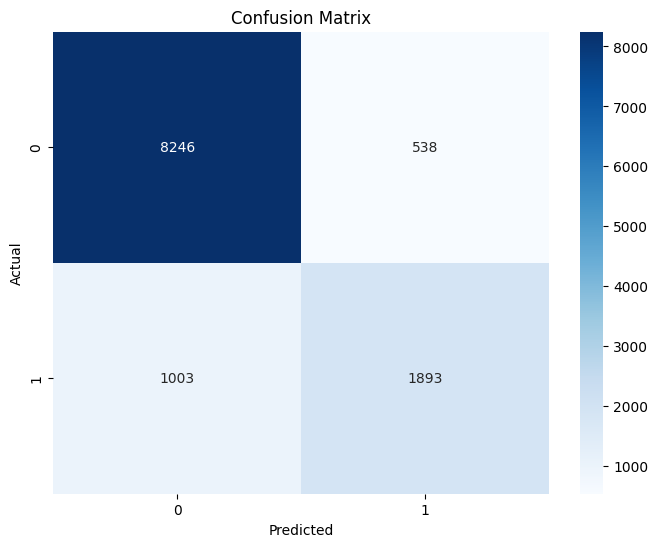

In [14]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<Figure size 1200x700 with 0 Axes>

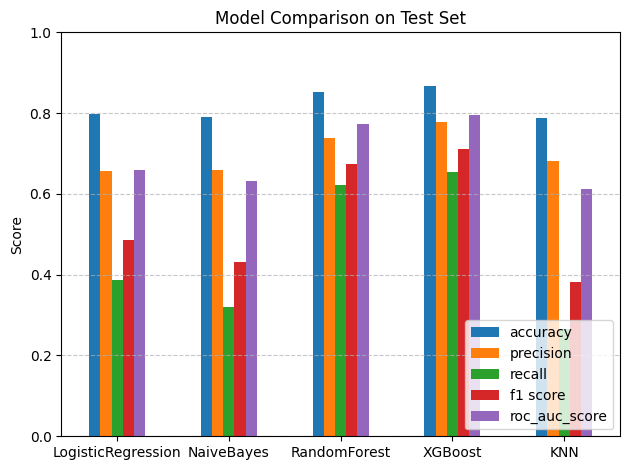

In [15]:
# Plotting analytics for model comparison
metrics = ['accuracy', 'precision', 'recall', 'f1 score', 'roc_auc_score']
report_numeric = report[metrics].astype(float)

plt.figure(figsize=(12, 7))
report_numeric.plot(kind='bar', rot=0)
plt.title('Model Comparison on Test Set')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()